In [1]:
# !pip3 install torchvision==0.5.0
# !pip3 install scikit-learn

In [1]:
from __future__ import print_function, division
import datetime
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.utils import save_image
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import cv2

In [2]:
for a,b in enumerate(os.listdir("data/deepdata")):
    print(a,b)

0 train
1 ana
2 t_test
3 val
4 new-data
5 all


In [3]:
class ThreadDataset(Dataset):
    def __init__(self,typ):
#         self.resize = transforms.Resize(25)
#         self.grayscame = transforms.Grayscale(num_output_channels=3)
#         self.randomhflip = transforms.RandomHorizontalFlip()
#         self.tensor = transforms.ToTensor()
#         self.normalise = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        self.samples = []
        for label,i in enumerate(os.listdir("data/deepdata/"+typ)):
            for j in os.listdir("data/deepdata/"+typ+"/"+i):
                im_bgr = cv2.imread("data/deepdata/"+typ+"/"+i+"/"+j)
                im_rgb = im_bgr[:, :, ::-1]
                self.samples.append((im_rgb,label,"data/deepdata/"+typ+"/"+i+"/"+j))
#                 print(im_rgb.shape)
            
        self.data_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(25,),
                transforms.Grayscale(num_output_channels=3),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        
        
        
    def __getitem__(self, index):
        
        image = self.samples[index][0]
        image = cv2.resize(image,(170,25))
        image = self.data_transforms(image)
        
        return (image,self.samples[index][1],self.samples[index][2])

    def __len__(self):
        return len(self.samples)


threadtrainDataset = ThreadDataset("train")
threadvalDataset = ThreadDataset("val")
# print(threadDataset.__getitem__(1)[0].shape)

In [4]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize(25),
#         transforms.Grayscale(num_output_channels=3),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(25),
#         transforms.Grayscale(num_output_channels=3),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }
# data_dir = 'data/deepdata'
# print(datasets.ImageFolder(os.path.join(data_dir, x)))
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

dataloaders = {"train":torch.utils.data.DataLoader(threadtrainDataset, batch_size=4,
                                             shuffle=True, num_workers=4),
               "val":torch.utils.data.DataLoader(threadvalDataset, batch_size=4,
                                             shuffle=True, num_workers=4)
              }

dataset_sizes = {"train":len(threadtrainDataset), "val":len(threadvalDataset) }

# print(dataloaders)
class_names = ["c","t"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

tensor([1, 1, 0, 0])


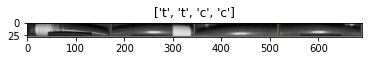

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes,path = next(iter(dataloaders['train']))
print(classes)
# # Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for (inputs, labels,paths) in dataloaders[phase]:
#                 print("length of data",inputs.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels,paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            print(datetime.datetime.now())
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(datetime.datetime.now())
            print(preds)
#             if 1 not in preds:
#                 continue
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 0.5706 Acc: 0.7609
val Loss: 0.5638 Acc: 0.7194

Epoch 1/29
----------
train Loss: 0.4813 Acc: 0.8055
val Loss: 0.5791 Acc: 0.7530

Epoch 2/29
----------
train Loss: 0.3545 Acc: 0.8747
val Loss: 0.4840 Acc: 0.8028

Epoch 3/29
----------
train Loss: 0.3071 Acc: 0.8904
val Loss: 0.2304 Acc: 0.9144

Epoch 4/29
----------
train Loss: 0.2673 Acc: 0.9098
val Loss: 0.7415 Acc: 0.6631

Epoch 5/29
----------
train Loss: 0.2359 Acc: 0.9177
val Loss: 0.2061 Acc: 0.9285

Epoch 6/29
----------
train Loss: 0.1747 Acc: 0.9390
val Loss: 0.2826 Acc: 0.8819

Epoch 7/29
----------
train Loss: 0.1207 Acc: 0.9622
val Loss: 0.1312 Acc: 0.9437

Epoch 8/29
----------
train Loss: 0.0988 Acc: 0.9678
val Loss: 0.1229 Acc: 0.9502

Epoch 9/29
----------
train Loss: 0.0873 Acc: 0.9701
val Loss: 0.1142 Acc: 0.9545

Epoch 10/29
----------
train Loss: 0.0795 Acc: 0.9749
val Loss: 0.1150 Acc: 0.9545

Epoch 11/29
----------
train Loss: 0.0658 Acc: 0.9768
val Loss: 0.1117 Acc: 0.9534

Ep

In [10]:
# mobilenet_model = models.mobilenet_v2(pretrained=True)
# # print(mobilenet_model)
# num_ftrs = mobilenet_model.classifier[1].in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# mobilenet_model.classifier[1] = nn.Linear(num_ftrs, 2)

# mobilenet_model = mobilenet_model.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
# model_ft = train_model(mobilenet_model, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

In [ ]:
!pip3 install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)







In [ ]:

# num_ftrs = efficientnet_model._fc.in_features
# print(num_ftrs)
# efficientnet_model._fc = nn.Linear(num_ftrs, 2)
# print(efficientnet_model)
efficientnet_model = efficientnet_model.to(device)


In [ ]:
efficientnet_model = train_model(efficientnet_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

In [11]:
print(device)

cuda:0


2020-12-30 16:11:37.757276
2020-12-30 16:11:37.763818
tensor([0, 0, 1, 0], device='cuda:0')


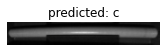

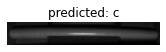

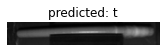

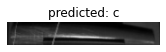

In [10]:
import datetime

# model_ft = model_ft.to("cpu")

visualize_model(model_ft,4)

plt.ioff()
plt.show()

In [11]:
# !pip3 install scikit-learn

In [12]:
import time
groundTruth = []
prediction = []
device= "cpu"
was_training = model_ft.training
model_ft = model_ft.to(device)
model_ft.eval()
# print(model_ft.training)
with torch.no_grad():
    for i, (inputs, labels,paths) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
#         print(inputs.shape)
#         print(labels)
        print(paths)
        print(time.time())
    
#         outputs = model_ft(inputs[0].unsqueeze(0))
        outputs = model_ft(inputs)

    
#         print(outputs)
        _, preds = torch.max(outputs, 1)
#         print(preds)
        print(time.time())
#         breakpoint()
        for i,val in enumerate(preds):
            if val != labels[i]:
    #             plt.savefig("./deepdata/ana/"+str(time.time())+".jpg")
    #             print(inputs[0].cpu().data[0].shape)
#                 save_image(inputs.cpu().data[i], "./data/deepdata/ana/-"+str(labels[i])+"-"+str(val)+str(time.time())+".jpg")
                ima = cv2.imread(paths[i])
                cv2.imwrite("./data/deepdata/ana/-"+str(labels[i])+"-"+str(val)+str(time.time())+".jpg",ima)
#             imshow(inputs.cpu().data[0])
#             break
#             cv2.imwrite("./deepdata/ana/"+str(time.time())+".jpg",inputs[0].cpu().data[0].numpy())
#             inputs.save("./deepdata/ana/"+str(time.time())+".jpg")
#         print(time.time())
#         break
#         print(preds)
        prediction.extend(preds.cpu().numpy())
        groundTruth.extend(labels.cpu().numpy())
    
model_ft.train(mode = True)
print("done------------>")

('data/deepdata/val/c/87.53331270427508.jpg', 'data/deepdata/val/t/1279.jpg', 'data/deepdata/val/c/88.85653803509015.jpg', 'data/deepdata/val/t/89.18511798732868.jpg')
1609324898.246722
1609324898.3253634
('data/deepdata/val/t/518.jpg', 'data/deepdata/val/t/2860.jpg', 'data/deepdata/val/t/1037.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-94.47069245487178.jpg')
1609324898.335824
1609324898.3728912
('data/deepdata/val/t/2088.jpg', 'data/deepdata/val/c/82.55708061958528.jpg', 'data/deepdata/val/t/2370.jpg', 'data/deepdata/val/t/1965.jpg')
1609324898.3734324
1609324898.398483
('data/deepdata/val/c/1601613624.8945053.jpg', 'data/deepdata/val/t/542.jpg', 'data/deepdata/val/t/3792.jpg', 'data/deepdata/val/t/3827.jpg')
1609324898.398989
1609324898.4261422
('data/deepdata/val/c/4990.jpg', 'data/deepdata/val/t/2551.jpg', 'data/deepdata/val/t/2568.jpg', 'data/deepdata/val/c/2020-12-28-1609148896.753661-87.1260230485254.jpg')
1609324898.4294732
1609324898.4596941
('data/deepdata/val/t

1609324899.544863
('data/deepdata/val/t/1562.jpg', 'data/deepdata/val/t/3932.jpg', 'data/deepdata/val/t/776.jpg', 'data/deepdata/val/t/1800.jpg')
1609324899.547157
1609324899.58088
('data/deepdata/val/t/337.jpg', 'data/deepdata/val/t/3777.jpg', 'data/deepdata/val/t/747.jpg', 'data/deepdata/val/t/4733.jpg')
1609324899.5825222
1609324899.6117997
('data/deepdata/val/t/92.63465719105646.jpg', 'data/deepdata/val/c/2020-12-28-1609148896.753661-84.4892419170123.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-86.57445752594514.jpg', 'data/deepdata/val/c/1601612488.9635897.jpg')
1609324899.6132667
1609324899.6430461
('data/deepdata/val/t/4164.jpg', 'data/deepdata/val/t/4962.jpg', 'data/deepdata/val/t/92.31747087043802.jpg', 'data/deepdata/val/t/1195.jpg')
1609324899.6446373
1609324899.6723945
('data/deepdata/val/t/2020-12-28-1609149180.6135726-91.06822471592616.jpg', 'data/deepdata/val/c/88.79309402837517.jpg', 'data/deepdata/val/t/93.6764388550993.jpg', 'data/deepdata/val/t/3251.jpg')

1609324900.8556485
('data/deepdata/val/t/3305.jpg', 'data/deepdata/val/t/3500.jpg', 'data/deepdata/val/t/1576.jpg', 'data/deepdata/val/t/546.jpg')
1609324900.858057
1609324900.887439
('data/deepdata/val/t/4787.jpg', 'data/deepdata/val/t/3214.jpg', 'data/deepdata/val/c/87.56610641008136.jpg', 'data/deepdata/val/c/88.4625760998324.jpg')
1609324900.8894434
1609324900.9131243
('data/deepdata/val/t/1884.jpg', 'data/deepdata/val/t/86.05713669334204.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-82.31345363103563.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-84.4225278657482.jpg')
1609324900.915246
1609324900.9385943
('data/deepdata/val/c/1601613446.031868.jpg', 'data/deepdata/val/c/86.74939777997457.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-82.70920308695763.jpg', 'data/deepdata/val/t/4472.jpg')
1609324900.9399593
1609324900.967752
('data/deepdata/val/t/2020-12-28-1609149180.6135726-92.58666249042628.jpg', 'data/deepdata/val/t/3374.jpg', 'data/deepdata/val

1609324902.176446
('data/deepdata/val/t/82.62301146652655.jpg', 'data/deepdata/val/t/78.jpg', 'data/deepdata/val/t/3931.jpg', 'data/deepdata/val/t/1095.jpg')
1609324902.1782591
1609324902.2086318
('data/deepdata/val/t/2721.jpg', 'data/deepdata/val/c/2020-12-28-1609148896.753661-89.62517881074477.jpg', 'data/deepdata/val/t/803.jpg', 'data/deepdata/val/c/87.88535710086659.jpg')
1609324902.2099874
1609324902.2375245
('data/deepdata/val/c/88.84119147813793.jpg', 'data/deepdata/val/t/1423.jpg', 'data/deepdata/val/t/1405.jpg', 'data/deepdata/val/c/1601615470.7716184.jpg')
1609324902.2396884
1609324902.26947
('data/deepdata/val/c/1601614752.9340236.jpg', 'data/deepdata/val/t/80.87255472126509.jpg', 'data/deepdata/val/c/1601613204.3905056.jpg', 'data/deepdata/val/t/457.jpg')
1609324902.2707539
1609324902.306285
('data/deepdata/val/t/1526.jpg', 'data/deepdata/val/t/90.4169149947642.jpg', 'data/deepdata/val/t/4960.jpg', 'data/deepdata/val/c/89.12254138212097.jpg')
1609324902.308101
1609324902.33

1609324907.6484776
('data/deepdata/val/t/2020-12-28-1609149180.6135726-93.16559002094871.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-91.10601623677526.jpg', 'data/deepdata/val/t/4108.jpg', 'data/deepdata/val/t/1384.jpg')
1609324907.6684098
1609324907.8239565
('data/deepdata/val/t/4523.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-94.63337052414144.jpg', 'data/deepdata/val/t/315.jpg', 'data/deepdata/val/t/2021.jpg')
1609324907.8331356
1609324907.9922554
('data/deepdata/val/t/4748.jpg', 'data/deepdata/val/t/541.jpg', 'data/deepdata/val/c/1601611415.2552285.jpg', 'data/deepdata/val/t/3799.jpg')
1609324908.0144286
1609324908.2109094
('data/deepdata/val/c/1601616106.228662.jpg', 'data/deepdata/val/t/98.64945214683947.jpg', 'data/deepdata/val/t/3168.jpg', 'data/deepdata/val/t/4132.jpg')
1609324908.231821
1609324908.441434
('data/deepdata/val/t/1555.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-98.29405476256603.jpg', 'data/deepdata/val/t/87.42037326011285.j

1609324912.3747249
('data/deepdata/val/t/2020-12-28-1609149180.6135726-88.11489607571438.jpg', 'data/deepdata/val/c/1601615310.850097.jpg', 'data/deepdata/val/t/675.jpg', 'data/deepdata/val/t/82.85398839120262.jpg')
1609324912.3766377
1609324912.4099576
('data/deepdata/val/t/3440.jpg', 'data/deepdata/val/c/1601615005.230952.jpg', 'data/deepdata/val/t/88.98706734348431.jpg', 'data/deepdata/val/c/2020-12-28-1609148896.753661-86.8101527947381.jpg')
1609324912.412129
1609324912.4421592
('data/deepdata/val/t/3755.jpg', 'data/deepdata/val/t/595.jpg', 'data/deepdata/val/t/1040.jpg', 'data/deepdata/val/t/2207.jpg')
1609324912.4445517
1609324912.4720228
('data/deepdata/val/t/4266.jpg', 'data/deepdata/val/t/1039.jpg', 'data/deepdata/val/t/80.4815003124153.jpg', 'data/deepdata/val/t/97.81100946001858.jpg')
1609324912.4734387
1609324912.5029867
('data/deepdata/val/t/4727.jpg', 'data/deepdata/val/t/2020-12-28-1609149180.6135726-84.7649328622926.jpg', 'data/deepdata/val/c/1601612161.0267725.jpg', 'd

In [13]:
print(groundTruth)

[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 

In [14]:
print(prediction)

[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(groundTruth, prediction)

array([[259,  14],
       [ 24, 626]])

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(groundTruth, prediction)

0.978125

In [17]:
recall_score(groundTruth, prediction)

0.963076923076923

In [18]:
from sklearn.metrics import f1_score
f1_score(groundTruth, prediction)

0.9705426356589147

In [19]:
#saving the model
torch.save(model_ft.state_dict(),"kirchi_model.pth")

In [ ]:
model_ft = models.resnet18(pretrained = False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.load_state_dict(torch.load("./kirchi_model.pth"))
model_ft = model_ft.to("cuda")